# Sentiment Analysis via Word2Vec

In [88]:
from __future__ import division
import numpy as np
from sklearn.datasets import load_files
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from nltk import RegexpTokenizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import os
from pprint import pprint
from sklearn.grid_search import ParameterGrid
from ipyparallel import Client
from gensim.models import Word2Vec
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from collections import Counter

%matplotlib inline

In [2]:
# helper functions
def get_sentiment_data(file_path):
    X = []
    y = []
    data_ = load_files(file_path, random_state=41)
    for label, data in zip(data_.target, data_.data):
        # FILTER OUT EMTPY REVIEWS 
        if data:
            X.append(data)
            y.append(label)
    return np.array(X), np.array(y)

def tokenize_reviews(X):
    reg_tokenizer = RegexpTokenizer(pattern=r'\w+')
    X_tokenized = []
    for review in X:
        x_sent = []
        for sentence in review.split("\n"):
            x_sent.extend(reg_tokenizer.tokenize(sentence))
        X_tokenized.append(x_sent)
    return X_tokenized

def get_bag_of_words(X):
    vectorizer = CountVectorizer(stop_words = "english")
    vectorizer.fit_transform(X)
    X_count = vectorizer.transform(X)
    return X_count

def buildSentanceVector(text, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec += imdb_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

def print_metrics(y_true, y_pred):
    print "Accuracy {:.3}".format(accuracy_score(y_true, y_pred))
    print "Precison {:.3}".format(precision_score(y_true, y_pred))
    print "Recall {:.3}".format(recall_score(y_true, y_pred))

In [3]:
# Data Engineering functions used to greatly speed up model optimization 
def persist_cv_splits(X, y, n_cv_iter=5, name='data', suffix="_cv_%03d.pkl", test_size=0.25, random_state=None):
    """Materialize randomized train test splits of a dataset."""

    cv = ShuffleSplit(X.shape[0], 
                      n_iter=n_cv_iter,
                      test_size=test_size, 
                      random_state=random_state)
    
    cv_split_filenames = []

    for i, (train, test) in enumerate(cv):
        
        cv_fold = (X[train], y[train], X[test], y[test])
        cv_split_filename = name + suffix % i
        cv_split_filename = os.path.abspath(cv_split_filename)
        joblib.dump(cv_fold, cv_split_filename)
        cv_split_filenames.append(cv_split_filename)
    
    return cv_split_filenames

def compute_evaluation(cv_split_filename, model, params):
    """Function executed by a worker to evaluate a model on a CV split"""
    # All module imports should be executed in the worker namespace
    from sklearn.externals import joblib

    X_train, y_train, X_validation, y_validation = joblib.load(
        cv_split_filename, mmap_mode='c')
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    validation_score = model.score(X_validation, y_validation)
    return validation_score

def grid_search(lb_view, model, cv_split_filenames, param_grid):
    """Launch all grid search evaluation tasks."""
    all_tasks = []
    all_parameters = list(ParameterGrid(param_grid))
    
    for i, params in enumerate(all_parameters):
        task_for_params = []
        
        for j, cv_split_filename in enumerate(cv_split_filenames):    
            t = lb_view.apply(
                compute_evaluation, cv_split_filename, model, params)
            task_for_params.append(t) 
        
        all_tasks.append(task_for_params)
        
    return all_parameters, all_tasks

def progress(tasks):
    return np.mean([task.ready() for task_group in tasks
                                 for task in task_group])

def find_bests(all_parameters, all_tasks, n_top=5):
    """Compute the mean score of the completed tasks"""
    mean_scores = []
    
    for param, task_group in zip(all_parameters, all_tasks):
        scores = [t.get() for t in task_group if t.ready()]
        if len(scores) == 0:
            continue
        mean_scores.append((np.mean(scores), param))
                   
    return sorted(mean_scores, reverse=True)[:n_top]

## Introduction
In my [previous attempts](https://github.com/AlexanderPhysics/DataBeast/blob/master/NaturalLanguageProcessing_NLP/FINAL_PROJECT_PRESENTATION.ipynb) at building a sentiment analysis model, I wasn't able to improve accracy much beyond 83%. The optmized machine learning ensemble that I built (comprised of Logistic Regression, SVC, and Navie Bayes) was only able to increase accuracy by 1%! These results told me that my optmized models simply weren't able to identify any additional signal from my bag-of-words repesentation of the IMDB reivews. More ingenuity was needed for feature engineering!

#### Word Context 

The problem with bag-of-words representation is that it doesn't capture any of the word's context. For instance, the word "sick" can have either positive or negative sentiment depending on the context in which it is used. "That movie was sick!" and "That move made me sick!" express polar opposite sentiment. Also, the bag-of-words representation only considers the frequency in which words appear in each review. In this example, the only differing words are "was" in the first sentance and "made me" in the second sentance. Not very informative. 

#### Curse of Dimensionality 

In the bag-of-words representation of text, every single unique word becomes a feature in the feature set. Typically resulting in a feature set whos size is in the thousands or even tens of thousands! Feature sets of this vastness create problems for machine learning classifers. Data sets this huge exist in a vector space where the majority of points are located far away from the origin, near the surface of the hyper-volume that they create. This results in sparsity in the data matrix,causing the performance of machine learning models to suffer. 

####  Feature Engineering with Word2Vec

Word2Vec is an artifical neural network that address the issues of word context and high dimensions. Word2Vec takes a word with a text representation and transforms it into a vector representation in a real-value vector space. The user can choose the dimensionality of that vector space, thus choosing to reduce the feature space by an order of magnitude or more. Additionally, Word2Vec also learns the contextual relationshps of each word and their placement in the vector space corresponds to their semantic meaning. For instance, vec("King") + vec("Queen") - vec("Man") = vec("Woman"). 

More information about Word2Vec can be found here:

[Original paper written by google](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

[A more mathamatical exposure](http://www-personal.umich.edu/~ronxin/pdf/w2vexp.pdf)



## Experiment

We will explore wheather or not Word2Vec can provide significant improvements on the bag-of-words represenation of imdb movie reviews. In the link to my previous attempts, you can see in cell 114 that the ensemble had the best performance with an $\textbf{accuracy}$ of $\textbf{0.8492}$ and a $\textbf{f1 score}$ of $\textbf{0.8270}$. 

#### Load and pre-process data

In [4]:
file_path = '/Users/Alexander/Documents/Data/sentiment/data/imdb1/'
X, Y = get_sentiment_data(file_path)

In [5]:
X, Y = shuffle(X, Y)
X_token = tokenize_reviews(X)
# shuffle and split data for machine learning
X_train, X_test, Y_train, Y_test = train_test_split(X_token, 
                                                    Y, 
                                                    test_size=0.20, 
                                                    random_state=4)

In [155]:
# explore other hyper-parameters
n_dim = 300
n_cores = 3
floor_freq = 5
n_iter = 30
# 1 -> softmax (best so far), 0 -> negative sampling
# which to use when
classifier = 1
# Initialize model and build vocab
imdb_w2v = Word2Vec(size=n_dim, 
                    workers=n_cores,
                    min_count=floor_freq,
                    hs=classifier,
                   iter=n_iter)
imdb_w2v.build_vocab(X_token)

In [156]:
# train word2vec over train reviews 
imdb_w2v.train(X_train);

In [157]:
# now words have a vector representaion in a 300 dim vector space
imdb_w2v['big'].shape

(300,)

#### Build Review Vectors

In [158]:
# build a vector representation for each review
# for each review, build sentance vectors and average them to get the review vector
# then scale each review vector to have zero mean and unit standard deviation (Normal Distribution)
X_train_vectors = np.concatenate([buildSentanceVector(review, n_dim) for review in X_train])
X_train_vectors = scale(X_train_vectors)

In [159]:
# build test set vectors as well
X_test_vectors = np.concatenate([buildSentanceVector(review, n_dim) for review in X_test])
X_test_vectors = scale(X_test_vectors)

### Optmize Hyper-parameters

In [32]:
digits_split_filenames = persist_cv_splits(X_train_vectors, np.array(Y_train), name='imdb', random_state=42)

In [165]:
!ipcluster stop

2016-06-20 14:50:52.154 [IPClusterStop] Stopping cluster [pid=3422] with [signal=2]


In [166]:
!ipcluster start -n=3 --daemon

In [167]:
client = Client()

In [172]:
len(client)

3

In [173]:
lb_view = client.load_balanced_view()
model = SVC()
svc_params = {'C': np.logspace(-1, 2, 4),
              'gamma': np.logspace(-4, 0, 5),
             'kernel': ["linear", "poly", "rbf", "sigmoid"]}

all_parameters, all_tasks = grid_search(
   lb_view, model, digits_split_filenames, svc_params)

In [187]:
print("Tasks completed: {0}%".format(100 * progress(all_tasks)))
pprint(find_bests(all_parameters, all_tasks))

Tasks completed: 80.5%
[(0.82450000000000012, {'C': 10.0, 'gamma': 0.0001, 'kernel': 'rbf'}),
 (0.82050000000000001, {'C': 10.0, 'gamma': 0.0001, 'kernel': 'sigmoid'}),
 (0.81900000000000017, {'C': 1.0, 'gamma': 0.001, 'kernel': 'sigmoid'}),
 (0.81900000000000017, {'C': 1.0, 'gamma': 0.001, 'kernel': 'rbf'}),
 (0.81200000000000006, {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'})]


The combination of hyperparameters that leads to the best performance, in terms of accuracy, for SVM is located in the top row. 

In [188]:
!ipcluster stop

2016-06-20 15:15:10.074 [IPClusterStop] Stopping cluster [pid=3461] with [signal=2]


#### Training machine learning classifier

In [189]:
# consider optimzing gbc
# model = GradientBoostingClassifier(n_estimators=1000)
# optimized svm
model = SVC(C=10.0, gamma=0.0001, kernel="rbf", probability=True)
#model = LogisticRegression()

In [190]:
model.fit(X_train_vectors, Y_train);

In [191]:
y_pred = model.predict(X_test_vectors)

In [192]:
print_metrics(Y_test, y_pred)

Accuracy 0.818
Precison 0.878
Recall 0.767


In [193]:
y_pred_prob = model.predict_proba(X_test_vectors)[:,1]

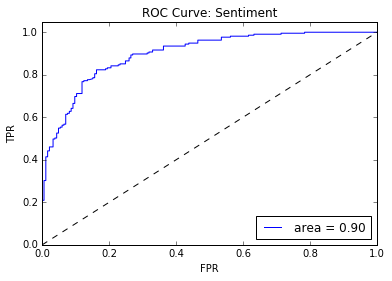

In [194]:
fpr,tpr,_ = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("ROC Curve: Sentiment")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend(loc='lower right')

plt.show()

### Results

After having leveraged Word2Vec, we see that the resulting performance is actually slightly worse than my previous attempts. One possible reason for this is that the review vectors are averaged sentance vectors. This means that even a positive review can be labeld negative because more sentances expressed negative sentiment than positive sentiment. 
    
A possible solution to this problem is to leverage doc2vec which can better capture the sentiment of an entire reivew, without having to take averages of sentance vectors.

The most convincing reason for this performance is the small sample size used to train Word2Vec. It is well known that neural networks need significantly large training sets to achieve great performance. Here, I insisted on using the same 2000 review IMBD data set so that I can compare the work in this notebook with my previous attempts. We can see from this preliminary experiment that Word2Vec shows promise but more data is needed! 